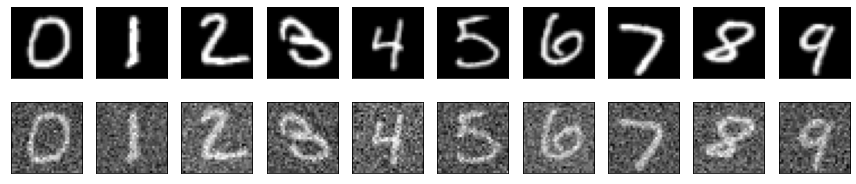

In [14]:
# %% imports
# pytorch
import torch
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader

# pyplot
import matplotlib.pyplot as plt

# %% Noisy MNIST dataset
class Noisy_MNIST(Dataset):
    # initialization of the dataset
    def __init__(self, split,data_loc,noise=0.5):
        # save the input parameters
        self.split    = split 
        self.data_loc = data_loc
        self.noise    = noise
        
        if self.split == 'train':
            Train = True
        else:
            Train = False
            
        # get the original MNIST dataset   
        Clean_MNIST = datasets.MNIST(self.data_loc, train=Train, download=True)
        
        # reshuffle the test set to have digits 0-9 at the start
        if self.split == 'train':
            data = Clean_MNIST.data.unsqueeze(1)
        else:
            data = Clean_MNIST.data.unsqueeze(1)
            idx = torch.load('test_idx.tar')
            data[:,:] = data[idx,:]
            
        
        # reshape and normalize
        resizer = transforms.Resize(32)
        resized_data = resizer(data)*1.0
        normalized_data = 2 *(resized_data/255) - 1
        #normalized_data = (resized_data - 33)/74
        
        # create the data
        self.Clean_Images = normalized_data
        self.Noisy_Images = normalized_data + torch.randn(normalized_data.size())*self.noise
        self.Labels       = Clean_MNIST.targets
    
    # return the number of examples in this dataset
    def __len__(self):
        return self.Labels.size(0)
    
    # create a a method that retrieves a single item form the dataset
    def __getitem__(self, idx):
        clean_image = self.Clean_Images[idx,:,:,:]
        noisy_image = self.Noisy_Images[idx,:,:,:]
        label =  self.Labels[idx]
        
        return clean_image,noisy_image,label
    
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    # These lines are added by me(Yunus) for creating a validation set
    Noisy_MNIST_val  = Noisy_MNIST("val" , data_loc)
    Noisy_MNIST_val_loader  =  DataLoader(Noisy_MNIST_val , batch_size=batch_size, shuffle=True, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader, Noisy_MNIST_val_loader

# %% test if the dataloaders work
if __name__ == "__main__":
    # define parameters
    data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
    batch_size = 64
    
    # get dataloader
    train_loader, test_loader,__ = create_dataloaders(data_loc, batch_size)
    
    # get some examples
    examples = enumerate(test_loader)
    _, (x_clean_example, x_noisy_example, labels_example) = next(examples)
    # use these example images througout the assignment as the first 10 correspond to the digits 0-9
    
    # show the examples in a plot
    plt.figure(figsize=(12,3))
    for i in range(10):
        plt.subplot(2,10,i+1)
        plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2,10,i+11)
        plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
    plt.show()

In [2]:
# Exc 1b)
import torch.nn as nn
import numpy as np
import os
import torch.optim as optim

In [91]:
class FFNN_1b(nn.Module):
    """
    A simple Feed Forward Neural Network
    
    Param
    ------------
    input_size : int (default = 786)         
        The length of the datasets which is width*height)
    n_hidden : int (default: 200)
        Number of hidden units.
    n_classes: int  (default = 10)        
        Number of the final classes, in our case 0-9 thus 10 classes.
    """
    def __init__(self, input_size=1024, hidden_size= 400, n_classes=10):
        super().__init__()
        
        self.flat = nn.Flatten()
        # First fully connected layer
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_size, 200)
        self.fc3 = nn.Linear(200, n_classes)
        #no activation functions yet
    def forward(self, x):
        # forward always defines connectivity
        x = self.flat(x)
        x = self.fc2(self.fc1(x))
        y = self.fc3(x)
        return y
    
    def predict(self,x):
        """Predict class labels
        Parameters
        -----------
        X : array, shape = [n_samples, n_features]
            Input layer with original features.
        Returns:
        ----------
        y_pred : array, shape = [n_samples]
            Predicted class labels.
        """
        # Implement prediction here
        a_out = self.forward(x).detach().numpy()
        result = np.zeros(len(a_out))
        for i in range(len(a_out)):
            j = np.argmax(a_out[i])
            result[i] = j
        y_pred = result
        return y_pred
    
model = FFNN_1b()



### Q 1.c)

For the network to start training, we also need an optimiser.
##### What is the goal of an optimiser within a Neural Network?
* It updates the weights based on the loss and the chosen algorithm to minimize the overall loss and increase the accuracy.

For the implementation, start with using the SGD (Stochastic Gradient Descent). This has similarities to the Steepest Gradient Descent algorithm.
##### What are the similarities and differences between the two optimisers?
* wekrjlkewrj

Start with a small learning rate to begin with. Once the model has been set up, make
sure you compile it.

In [117]:
## 1c)
learning_rate = 1e-2 # small learning rate
optimizer = optim.SGD(model.parameters(), lr=learning_rate)  ## SGD optimizer
criterion = nn.CrossEntropyLoss()

epochs = 3

dir_data = os.path.abspath("data")
dir_truth = os.path.join(dir_data, "gtFine")
torch.save(model.state_dict(), os.path.join("./", "model_unet_base_line.pth"))

### Q 1.d)

During training, make sure that you save the weights from your model to a folder, you
may look up the code on pytorch’s website. To ensure that your model can actually
run, make a prediction with the untrained network using the test set (after splitting
your data into the training-validation-test sets).

Plot the prediction alongside the test data. Comment on the prediction of the untrained
model. 
##### Why does it look the way it does?
* wkerjwekrj

In [45]:
## create the dataloaders
# define parameters
data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
batch_size = 64

# get dataloader
train_loader, test_loader, val_loader= create_dataloaders(data_loc, batch_size)

In [116]:
#### Simple accuracy checker
def check_accuracy_V1(loader, model, noise=False):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    print('Checking accuracy validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, data in loader:
            if noise:
                _, x, y = data
            else:
                x, _, y = data
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct, Val_Accuracy: %.2f%%' % (num_correct, num_samples, 100 * acc))

In [132]:
import torch.nn.functional as F  # useful stateless functions
write_to_file = False
noise = False
USE_GPU = True
# Use GPU/CPU
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = model.to(device=device)

#
print_every = 100

################ Simple trainer ####################
#used for plotting the loss
losses = []
losses_val = []
for epoch in range(epochs):

    # Used for calculating accuracy
    num_correct = 0
    num_samples = 0
    num_correct_val = 0
    num_samples_val = 0
    #used for plotting the loss
    running_loss = 0.0 
    running_loss_val = 0.0 
    
    # Get iteration t, input x, noisy input xn, label y
    for t, data in enumerate(train_loader):
        model.train() # put the model in training mode, only important for batchnorm- and dropout-layers
        x, xn, y = data
        # cast the input and labels to the device, e.g. GPU
        ######################### note that we do not train on the noise data xn yet!
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)
        
        
        # forward
        scores = model(x)
        loss = criterion(scores,y)
        
        #Check Accuracy
        _, preds = scores.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        
        # This is the backwards pass: compute the gradient of the loss with
        # respect to each  parameter of the model.
        loss.backward()
        
        # Zero out all of the parameter gradients for the variables which the optimizer
        # will update.
        optimizer.zero_grad()
        
        # Actually update the parameters of the model using the gradients
        # computed by the backwards pass.
        optimizer.step()
        




    
    
        ######## validation operations
#         model.eval()  # set model to evaluation mode
#         with torch.no_grad():
#             for data in val_loader:
#                 # validation on noisy part or not
#                 if noise:
#                     _, x_val, y_val = data
#                 else:
#                     x_val, _, y_val = data
#                 # cast the values    
#                 x_val = x_val.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#                 y_val = y_val.to(device=device, dtype=torch.long)
                
#                 # calculate score and loss
#                 scores_val = model(x_val)
#                 loss_val = criterion(scores_val,y_val)
                
#                 # save the losses for validation
#                 running_los_val =+ loss_val.item()
#                 _, preds_val = scores_val.max(1)
                
#                 num_correct_val += (preds_val == y_val).sum()
#                 num_samples_val += preds_val.size(0)
#             acc_val = float(num_correct_val) / num_samples_val
#             print('Got %d / %d correct, Val_Accuracy: %.2f%%' % (num_correct_val, num_samples_val, 100 * acc_val))

        # print statistics
        if t % print_every == 0:
            print('Epoch %d, Iteration %d, loss %.5f,' % (epoch, t,loss.item()))
            print('Got %d / %d correct, Train Accuracy: %.2f%%' % (num_correct, num_samples, 100 * acc))
#             check_accuracy_V1(loader_val, model)
            print()
    
    
        # Save the model paramters
        if write_to_file:        
            # Save the weights of the model to a .pt file
            torch.save(model.state_dict(), os.path.join("./", "Saved_Model.pth"))
            
        #save the losses for training
        running_loss =+ loss.item() * x.size(0)
        

        
        
        
        
    # loss per epoch
    epoch_loss=(running_loss / len(train_loader))
    losses.append(epoch_loss)

Epoch 0, Iteration 0, loss 2.30149,
Got 9 / 64 correct, Train Accuracy: 14.06%

Epoch 0, Iteration 100, loss 2.32779,
Got 795 / 6464 correct, Train Accuracy: 12.30%

Epoch 0, Iteration 200, loss 2.27227,
Got 1579 / 12864 correct, Train Accuracy: 12.27%

Epoch 0, Iteration 300, loss 2.30340,
Got 2343 / 19264 correct, Train Accuracy: 12.16%

Epoch 0, Iteration 400, loss 2.31415,
Got 3053 / 25664 correct, Train Accuracy: 11.90%

Epoch 0, Iteration 500, loss 2.27502,
Got 3803 / 32064 correct, Train Accuracy: 11.86%

Epoch 0, Iteration 600, loss 2.28781,
Got 4582 / 38464 correct, Train Accuracy: 11.91%

Epoch 0, Iteration 700, loss 2.29314,
Got 5310 / 44864 correct, Train Accuracy: 11.84%

Epoch 0, Iteration 800, loss 2.31776,
Got 6042 / 51264 correct, Train Accuracy: 11.79%

Epoch 0, Iteration 900, loss 2.29949,
Got 6787 / 57664 correct, Train Accuracy: 11.77%

Epoch 1, Iteration 0, loss 2.32416,
Got 8 / 64 correct, Train Accuracy: 12.50%

Epoch 1, Iteration 100, loss 2.27884,
Got 766 / 64

### Q1.e)
Now, all that’s left to do is to actually train your model! At this point, you’re also
ready to plot the loss from the training process. Both training losses and the validation
losses.
Plot the training loss and the validation loss in one graph, with the proper labels (and
a legend).
##### How could you utilise this information to assess the quality of your model?
*

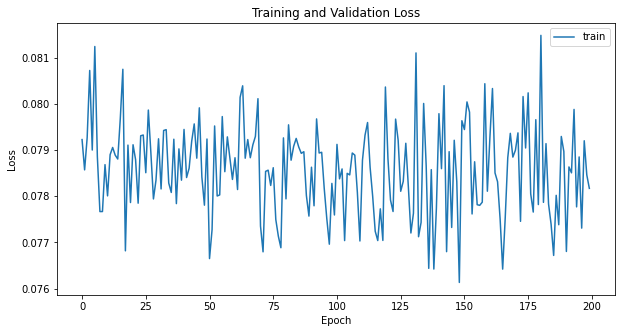

In [115]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
# plt.plot(losses_val,label="val")
plt.plot(losses,label="train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [95]:
# def train_part34(model, optimizer, epochs=1, write_to_file=False, USE_GPU=True):
#     """
#     Fit the model on the training data set.
#     Arguments
#     ---------
#     model : model class
#         Model structure to fit, as defined by build_model().
#     epochs :  int
#         Number of epochs the training should do
#     optimizer : optim class
#         Optimizer to use
#     write_to_file : bool (default:False)
#         Write model to file; can later be loaded through load_model()
#     USE_GPU : bool (default:True
#         Parameters that when set to True uses the GPU for the training
#     Returns
#     -------
#     model : model class
#         The trained model.
#     """
#     # First check if we have GPU we can use to train
#     dtype = torch.float32
#     if USE_GPU and torch.cuda.is_available():
#         device = torch.device('cuda')
#     else:
#         device = torch.device('cpu')
#     model = model.to(device=device)  # Move the model parameters to CPU/GPU
#     print_every = 100 # Constant to control how frequently we print train loss
    
#     for e in range(epochs):
#         for t, (x, y) in enumerate(loader_train):
#             model.train()  # put model to training mode
#             x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=torch.long)

#             scores = model(x)
#             loss = F.cross_entropy(scores, y)

#             # Zero out all of the gradients for the variables which the optimizer
#             # will update.
#             optimizer.zero_grad()

#             # This is the backwards pass: compute the gradient of the loss with
#             # respect to each  parameter of the model.
#             loss.backward()

#             # Actually update the parameters of the model using the gradients
#             # computed by the backwards pass.
#             optimizer.step()

#             if t % print_every == 0:
#                 print('Iteration %d, loss = %.4f' % (t, loss.item()))
#                 check_accuracy_part34(loader_val, model)
#                 print()

#     #### Save the model
#     print(acc)
#     if write_to_file:        
#         # Save the weights of the model to a .pt file
# #         print(MODEL_NEW)
# #         torch.save(model.state_dict(), MODEL_NEW)
#         torch.save(model.state_dict(), os.path.join("./", "Saved_Model.pth"))

#     return model

In [94]:
# # define parameters
# data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
# batch_size = 64

# # get dataloader
# train_loader, test_loader = create_dataloaders(data_loc, batch_size)

In [12]:
# print(train_loader)

ValueError: too many values to unpack (expected 2)

In [ ]:
# def check_accuracy_part2(loader, model_fn, params):
#     """
#     Check the accuracy of a classification model.
    
#     Inputs:
#     - loader: A DataLoader for the data split we want to check
#     - model_fn: A function that performs the forward pass of the model,
#       with the signature scores = model_fn(x, params)
#     - params: List of PyTorch Tensors giving parameters of the model
    
#     Returns: Nothing, but prints the accuracy of the model
#     """
#     split = 'val' if loader.dataset.train else 'test'
#     print('Checking accuracy on the %s set' % split)
#     num_correct, num_samples = 0, 0
#     with torch.no_grad():
#         for x, y in loader:
#             x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
#             y = y.to(device=device, dtype=torch.int64)
#             scores = model_fn(x, params)
#             _, preds = scores.max(1)
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         acc = float(num_correct) / num_samples
#         print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))